In [1]:
%matplotlib inline
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() 
from matplotlib import pyplot

# Data Processing 
import os
import os.path
import random
import PIL
import glob
from PIL import Image # to read images


### Use Keras Model Architecture 

In [2]:
#For Keras model
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image
import tensorflow as tf

Using TensorFlow backend.


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix,classification_report

### Dataset Preparation 

In [4]:
dataset_path = './data'
anns_file_path = dataset_path + '/' + 'annotations.json'

In [5]:
# Read Annotations
with open(anns_file_path , 'r') as f:
    dataset = json.loads(f.read())

In [6]:
categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

print(nr_images) # Total Number of images

1500


In [7]:
# category Dataframe and  Select 'six new Category(ouput classes)' for category Dataframe
cat_df = pd.DataFrame(categories)
keyValList = ['Cigarette','Clear plastic bottle','Drink can','Plastic straw','Glass bottle']
category_df = pd.DataFrame([d for d in categories if d['name'] in keyValList])

# Annotation Dataframe
ann_df = pd.DataFrame(anns)
# Images Dataframe
image_df = pd.DataFrame(imgs)

In [8]:
# Dropping unncessary columns for Keras fundamental CNN model
category_df = category_df.drop(['supercategory'], axis = 1)
image_df = image_df.drop(['license','flickr_url','coco_url','date_captured','flickr_640_url'], axis=1)
ann_df = ann_df.drop(['id'], axis=1)

In [9]:
merged_img_ann_df = pd.merge(left=image_df, right=ann_df, left_on='id', right_on='image_id')
final_merged_df = pd.merge(left=merged_img_ann_df, right=category_df, left_on='category_id', right_on='id') 
final_merged_df = final_merged_df.drop(['id_x','id_y','category_id','image_id','width','height'], axis = 1 )
final_merged_df = final_merged_df.rename(columns={"file_name": "filename", "name": "category"})
final_merged_df.head()

,filename,segmentation,area,bbox,iscrowd,category
0,batch_1/000006.jpg,"[[561.0, 1238.0, 568.0, 1201.0, 567.0, 1175.0,...",403954.0,"[517.0, 127.0, 447.0, 1322.0]",0,Glass bottle
1,batch_1/000012.jpg,"[[481.0, 1148.0, 505.0, 1163.0, 519.0, 1172.0,...",43489.0,"[379.0, 1127.0, 425.0, 318.0]",0,Glass bottle
2,batch_1/000048.jpg,"[[586.0, 820.0, 581.0, 851.0, 579.0, 889.0, 58...",324005.0,"[211.0, 1.0, 417.0, 1417.0]",0,Glass bottle
3,batch_1/000021.jpg,"[[1001.0, 867.0, 1163.0, 905.0, 1199.0, 913.0,...",95494.5,"[852.0, 638.0, 687.0, 291.0]",0,Glass bottle
4,batch_1/000022.jpg,"[[919.0, 1125.0, 968.0, 1111.0, 1000.0, 1100.0...",142823.0,"[647.0, 1033.0, 820.0, 376.0]",0,Glass bottle


In [10]:
# New Dataframe with selective columns
df = final_merged_df[['filename','bbox','category']]

In [11]:
# storing bounding box values as seperate columns
df = pd.concat([df , df['bbox'].apply(pd.Series)], axis = 1)
df.columns = ['filename','bbox','category', 'x_min','y_min','x_max', 'y_max'] # x_max : width and y_max : height
df = df.drop(['bbox',], axis=1)

In [12]:
df.head()

,filename,category,x_min,y_min,x_max,y_max
0,batch_1/000006.jpg,Glass bottle,517.0,127.0,447.0,1322.0
1,batch_1/000012.jpg,Glass bottle,379.0,1127.0,425.0,318.0
2,batch_1/000048.jpg,Glass bottle,211.0,1.0,417.0,1417.0
3,batch_1/000021.jpg,Glass bottle,852.0,638.0,687.0,291.0
4,batch_1/000022.jpg,Glass bottle,647.0,1033.0,820.0,376.0


In [13]:
# Calculate maximum x and maximum y points
df['x_max'] = df['x_max']+df['x_min']
df['y_max'] = df['y_max']+df['y_min']
# Convert float columns to integer
for col in  df.columns[2:]:
    df[col] = df[col].astype(int)
    

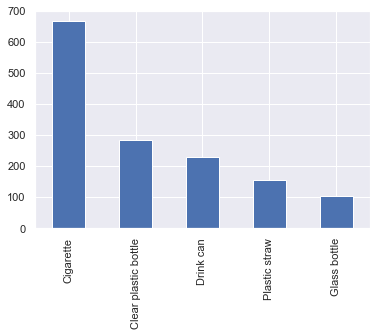

In [14]:
df['category'].value_counts().plot.bar()

Data splitting into train and test data and keep this test data aside for model prediction
train_df, test_df = train_test_split(df, test_size=0.10, random_state=42)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

### Fetch, crop and store image data

In [15]:
# Reading all the images from multiple folders and added to the list
folders = glob.glob(dataset_path +'//*')
imagenames_list = []
for folder in folders:
    for f in glob.glob(folder+'/*'):   
        imagenames_list.append(f)

In [16]:
train_data = []  
for ind in df.index:
    bbox = (df['x_min'][ind],df['y_min'][ind],df['x_max'][ind],df['y_max'][ind])
    img=Image.open(os.path.join(dataset_path,df['filename'][ind]))
    img=img.crop(bbox)
    img = img.resize((128, 128), Image.ANTIALIAS)
    img = image.img_to_array(img)
    train_data.append(img)

X = np.array(train_data)

In [17]:
df = df.drop(['x_min','x_max','y_min','y_max'], axis=1)
#test_df = test_df.drop(['x_min','x_max','y_min','y_max'], axis=1)

In [18]:
df.head()

,filename,category
0,batch_1/000006.jpg,Glass bottle
1,batch_1/000012.jpg,Glass bottle
2,batch_1/000048.jpg,Glass bottle
3,batch_1/000021.jpg,Glass bottle
4,batch_1/000022.jpg,Glass bottle


In [19]:
df = pd.get_dummies(df, columns=["category"])
df.head()

,filename,category_Cigarette,category_Clear plastic bottle,category_Drink can,category_Glass bottle,category_Plastic straw
0,batch_1/000006.jpg,0,0,0,1,0
1,batch_1/000012.jpg,0,0,0,1,0
2,batch_1/000048.jpg,0,0,0,1,0
3,batch_1/000021.jpg,0,0,0,1,0
4,batch_1/000022.jpg,0,0,0,1,0


In [20]:
# 
y = np.array(df.drop(['filename'],axis=1))
print(y.shape)
print(X.shape)

(1442, 5)
(1442, 128, 128, 3)


### Data Split 

In [21]:
# Data split Randomly
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

### Build Keras Model 

In [22]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(128,128,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

In [23]:
#Model Summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 124, 124, 16)      1216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 58, 58, 32)        12832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 29, 29, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 64)       

## Keras Model Implementation Using 'Accuracy' Method

In [24]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
# Model fit
history = model.fit(X_train, y_train, epochs=200,batch_size=50, validation_split=0.20)


Train on 1037 samples, validate on 260 samples
Epoch 1/200
1037/1037 [==============================] - 20s 19ms/step - loss: 13.4160 - accuracy: 0.3134 - val_loss: 1.5774 - val_accuracy: 0.4885
Epoch 2/200
1037/1037 [==============================] - 16s 16ms/step - loss: 1.5572 - accuracy: 0.4812 - val_loss: 1.5175 - val_accuracy: 0.4923
Epoch 3/200
1037/1037 [==============================] - 17s 17ms/step - loss: 1.5031 - accuracy: 0.4937 - val_loss: 1.4562 - val_accuracy: 0.5038
Epoch 4/200
1037/1037 [==============================] - 17s 17ms/step - loss: 1.4522 - accuracy: 0.4995 - val_loss: 1.3891 - val_accuracy: 0.5077
Epoch 5/200
1037/1037 [==============================] - 17s 16ms/step - loss: 1.3557 - accuracy: 0.5130 - val_loss: 1.2201 - val_accuracy: 0.5077
Epoch 6/200
1037/1037 [==============================] - 17s 17ms/step - loss: 1.2854 - accuracy: 0.5005 - val_loss: 1.1454 - val_accuracy: 0.5308
Epoch 7/200
1037/1037 [==============================] - 17s 16ms/step

1037/1037 [==============================] - 16s 16ms/step - loss: 0.9686 - accuracy: 0.6027 - val_loss: 0.9858 - val_accuracy: 0.6154
Epoch 57/200
1037/1037 [==============================] - 17s 16ms/step - loss: 0.9397 - accuracy: 0.6172 - val_loss: 1.0440 - val_accuracy: 0.5808
Epoch 58/200
1037/1037 [==============================] - 17s 16ms/step - loss: 0.9926 - accuracy: 0.5979 - val_loss: 1.0492 - val_accuracy: 0.5615
Epoch 59/200
1037/1037 [==============================] - 17s 17ms/step - loss: 0.9568 - accuracy: 0.6152 - val_loss: 0.9881 - val_accuracy: 0.6154
Epoch 60/200
1037/1037 [==============================] - 19s 18ms/step - loss: 0.9491 - accuracy: 0.6230 - val_loss: 1.0144 - val_accuracy: 0.5846
Epoch 61/200
1037/1037 [==============================] - 19s 18ms/step - loss: 0.9298 - accuracy: 0.6307 - val_loss: 0.9720 - val_accuracy: 0.6308
Epoch 62/200
1037/1037 [==============================] - 17s 17ms/step - loss: 0.9456 - accuracy: 0.6191 - val_loss: 0.9382 

1037/1037 [==============================] - 18s 17ms/step - loss: 0.8052 - accuracy: 0.6905 - val_loss: 0.8913 - val_accuracy: 0.6769
Epoch 112/200
1037/1037 [==============================] - 19s 18ms/step - loss: 0.7763 - accuracy: 0.6885 - val_loss: 0.8877 - val_accuracy: 0.6462
Epoch 113/200
1037/1037 [==============================] - 22s 22ms/step - loss: 0.7514 - accuracy: 0.7059 - val_loss: 0.9301 - val_accuracy: 0.6346
Epoch 114/200
1037/1037 [==============================] - 19s 18ms/step - loss: 0.7893 - accuracy: 0.6943 - val_loss: 0.8681 - val_accuracy: 0.6423
Epoch 115/200
1037/1037 [==============================] - 17s 16ms/step - loss: 0.7697 - accuracy: 0.7059 - val_loss: 0.9683 - val_accuracy: 0.6385
Epoch 116/200
1037/1037 [==============================] - 17s 16ms/step - loss: 0.7639 - accuracy: 0.7136 - val_loss: 0.9382 - val_accuracy: 0.6500
Epoch 117/200
1037/1037 [==============================] - 17s 16ms/step - loss: 0.7409 - accuracy: 0.6991 - val_loss: 0

1037/1037 [==============================] - 20s 19ms/step - loss: 0.4967 - accuracy: 0.8245 - val_loss: 1.1570 - val_accuracy: 0.6923
Epoch 167/200
1037/1037 [==============================] - 20s 19ms/step - loss: 0.5059 - accuracy: 0.8139 - val_loss: 1.0124 - val_accuracy: 0.6808
Epoch 168/200
1037/1037 [==============================] - 17s 17ms/step - loss: 0.4903 - accuracy: 0.8274 - val_loss: 1.2466 - val_accuracy: 0.6846
Epoch 169/200
1037/1037 [==============================] - 17s 16ms/step - loss: 0.5429 - accuracy: 0.8042 - val_loss: 1.1014 - val_accuracy: 0.6769
Epoch 170/200
1037/1037 [==============================] - 16s 15ms/step - loss: 0.4909 - accuracy: 0.8274 - val_loss: 1.0915 - val_accuracy: 0.6615
Epoch 171/200
1037/1037 [==============================] - 16s 15ms/step - loss: 0.5030 - accuracy: 0.8206 - val_loss: 1.1930 - val_accuracy: 0.6962
Epoch 172/200
1037/1037 [==============================] - 16s 15ms/step - loss: 0.5099 - accuracy: 0.8177 - val_loss: 1

### Model Evaluation Based on Accuracy metrics

In [26]:
# evaluate the model
_, train_acc = model.evaluate(X_train, y_train)
_, test_acc = model.evaluate(X_test, y_test)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

145/145 [==============================] - 1s 5ms/step
Train: 0.871, Test: 0.724


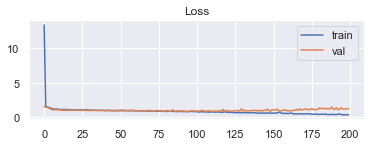

In [27]:
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()

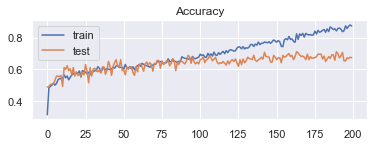

In [28]:
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

### Model Prediction 

In [29]:
classes = np.array(df.columns[1:])
proba = model.predict(X_test)

In [30]:
all_5 = np.argsort(proba[0])
for i in range(5):
    print("{}".format(classes[all_5[i]])+" ({:.3})".format(proba[0][all_5[i]]))

category_Cigarette (2.06e-06)
category_Plastic straw (0.00031)
category_Glass bottle (0.00432)
category_Drink can (0.302)
category_Clear plastic bottle (0.694)


## Keras Model Implementation Using 'MSE' Method

In [31]:
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mse'])

In [32]:
# Model fit
history = model.fit(X_train, y_train, epochs=100,batch_size=100,validation_split=0.20)

Train on 1037 samples, validate on 260 samples
Epoch 1/100
1037/1037 [==============================] - 20s 20ms/step - loss: 0.2219 - mse: 0.1954 - val_loss: 0.1997 - val_mse: 0.1977
Epoch 2/100
1037/1037 [==============================] - 21s 20ms/step - loss: 0.2114 - mse: 0.2066 - val_loss: 0.1794 - val_mse: 0.1765
Epoch 3/100
1037/1037 [==============================] - 18s 17ms/step - loss: 0.2226 - mse: 0.2208 - val_loss: 0.1819 - val_mse: 0.1805
Epoch 4/100
1037/1037 [==============================] - 17s 16ms/step - loss: 0.2175 - mse: 0.2173 - val_loss: 0.2031 - val_mse: 0.2031
Epoch 5/100
1037/1037 [==============================] - 17s 17ms/step - loss: 0.2210 - mse: 0.2210 - val_loss: 0.2031 - val_mse: 0.2031
Epoch 6/100
1037/1037 [==============================] - 17s 16ms/step - loss: 0.2210 - mse: 0.2210 - val_loss: 0.2031 - val_mse: 0.2031
Epoch 7/100
1037/1037 [==============================] - 17s 17ms/step - loss: 0.2210 - mse: 0.2210 - val_loss: 0.2031 - val_mse: 0

1037/1037 [==============================] - 19s 18ms/step - loss: 0.2210 - mse: 0.2210 - val_loss: 0.2031 - val_mse: 0.2031
Epoch 61/100
1037/1037 [==============================] - 17s 17ms/step - loss: 0.2210 - mse: 0.2210 - val_loss: 0.2031 - val_mse: 0.2031
Epoch 62/100
1037/1037 [==============================] - 17s 16ms/step - loss: 0.2210 - mse: 0.2210 - val_loss: 0.2031 - val_mse: 0.2031
Epoch 63/100
1037/1037 [==============================] - 17s 16ms/step - loss: 0.2210 - mse: 0.2210 - val_loss: 0.2031 - val_mse: 0.2031
Epoch 64/100
1037/1037 [==============================] - 17s 16ms/step - loss: 0.2210 - mse: 0.2210 - val_loss: 0.2031 - val_mse: 0.2031
Epoch 65/100
1037/1037 [==============================] - 17s 16ms/step - loss: 0.2210 - mse: 0.2210 - val_loss: 0.2031 - val_mse: 0.2031
Epoch 66/100
1037/1037 [==============================] - 17s 16ms/step - loss: 0.2210 - mse: 0.2210 - val_loss: 0.2031 - val_mse: 0.2031
Epoch 67/100
1037/1037 [=======================

### Model Evaluation Based on Mean Square Error metrics

In [33]:
# evaluate the model
_, train_mse = model.evaluate(X_train, y_train)
print('Train: %.3f' % (train_mse))

1297/1297 [==============================] - 5s 4ms/step
Train: 0.217


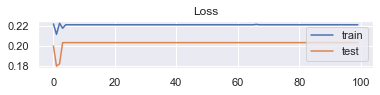

In [34]:
# plot loss during training
pyplot.subplot(411)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()

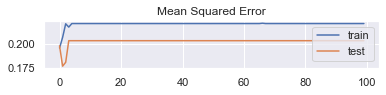

In [35]:
# plot mse during training
pyplot.subplot(412)
pyplot.title('Mean Squared Error')
pyplot.plot(history.history['mse'], label='train')
pyplot.plot(history.history['val_mse'], label='test')
pyplot.legend()
pyplot.show()